In [84]:
# ha senso analizzare un solo giocatore e addestrare con i suoi dati?
#come scegliere p e q guardando i grafici di autocorrelazione parziale e non
#true e false nel predict

In [85]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [87]:
percorso_csv = r"../../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [88]:
df_per_previsione = df_player_valuations[["date", "market_value_in_eur", "player_id"]]
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

# Trova i giocatori che hanno almeno una data nel 2023
players_with_2023_dates = df_per_previsione[df_per_previsione['date'].dt.year == 2023]['player_id'].unique()

# Filtra il DataFrame originale per i giocatori trovati
df_per_previsione = df_per_previsione[df_per_previsione['player_id'].isin(players_with_2023_dates)]

# Stampa il DataFrame risultante
#print(df_per_previsione)

C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\2884229399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])


In [89]:
pd.reset_option("display.max_row")
df_appearances['date'] = pd.to_datetime(df_appearances['date'])

player_gol = df_appearances.groupby(['player_id', df_appearances['date'].dt.to_period("M")]).agg({'goals': 'sum', 'assists': 'sum', 'red_cards':'sum'}).reset_index()

player_gol["date"] = player_gol["date"].dt.to_timestamp()
print(player_gol)


        player_id       date  goals  assists  red_cards
0              10 2012-08-01      1        0          0
1              10 2012-09-01      3        1          0
2              10 2012-10-01      3        0          0
3              10 2012-11-01      2        0          0
4              10 2012-12-01      2        0          0
...           ...        ...    ...      ...        ...
512047    1173042 2023-12-01      0        0          0
512048    1176345 2023-11-01      0        0          0
512049    1176345 2023-12-01      0        0          0
512050    1186012 2023-11-01      0        0          0
512051    1186012 2023-12-01      0        0          0

[512052 rows x 5 columns]


In [90]:
#pd.set_option('display.max_row', None)
df_per_previsione['date'] = df_per_previsione['date'].dt.to_period('M').dt.to_timestamp()
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

#Espandi il DataFrame
expanded_data = []

#Raggruppa per player_id
for player_id, group in df_per_previsione.groupby('player_id'):
    player_data = group.sort_values('date')
    
    #Crea un DataFrame con tutte le date del mese e giorno 1
    all_dates = pd.date_range(player_data['date'].min(), player_data['date'].max(), freq='MS')
    all_dates_df = pd.DataFrame({'date': all_dates})
    
    # Unisci il DataFrame con tutte le date con i dati esistenti
    player_data_expanded = pd.merge(all_dates_df, player_data, on='date', how='left')
    
    # Riempie le date mancanti con i valori precedenti/futuri già esistenti
    player_data_expanded['market_value_in_eur'] = player_data_expanded['market_value_in_eur'].ffill().bfill()
    player_data_expanded['player_id'] = player_data_expanded['player_id'].ffill().bfill()

    expanded_data.append(player_data_expanded)

# Concatena tutti i DataFrame espansi
df_expanded = pd.concat(expanded_data, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
df_expanded.to_csv('../../csv_post_etl/serie_temp_post.csv', index=False)

In [91]:
df_previsione_post_etl = pd.read_csv(percorso_csv + "/serie_temp_post.csv")


In [92]:
print(df_previsione_post_etl)

               date  market_value_in_eur  player_id
0        2004-10-01            7500000.0      215.0
1        2004-11-01            4000000.0      215.0
2        2004-12-01            4000000.0      215.0
3        2005-01-01            4000000.0      215.0
4        2005-02-01            4000000.0      215.0
...             ...                  ...        ...
1781115  2023-12-01             150000.0  1173042.0
1781116  2023-12-01             150000.0  1176345.0
1781117  2023-10-01             100000.0  1186012.0
1781118  2023-11-01             100000.0  1186012.0
1781119  2023-12-01             350000.0  1186012.0

[1781120 rows x 3 columns]


In [93]:
#print(df_expanded)
#pd.set_option("display.max_row", None)
pd.reset_option("display.max_row")

df_previsione_post_etl['date'] = pd.to_datetime(df_previsione_post_etl['date'])

df_previsione_post_etl = pd.merge(df_previsione_post_etl, player_gol, on = ["player_id", "date"], how = "left")
print(df_previsione_post_etl)



              date  market_value_in_eur  player_id  goals  assists  red_cards
0       2004-10-01            7500000.0      215.0    NaN      NaN        NaN
1       2004-11-01            4000000.0      215.0    NaN      NaN        NaN
2       2004-12-01            4000000.0      215.0    NaN      NaN        NaN
3       2005-01-01            4000000.0      215.0    NaN      NaN        NaN
4       2005-02-01            4000000.0      215.0    NaN      NaN        NaN
...            ...                  ...        ...    ...      ...        ...
1781115 2023-12-01             150000.0  1173042.0    0.0      0.0        0.0
1781116 2023-12-01             150000.0  1176345.0    0.0      0.0        0.0
1781117 2023-10-01             100000.0  1186012.0    NaN      NaN        NaN
1781118 2023-11-01             100000.0  1186012.0    0.0      0.0        0.0
1781119 2023-12-01             350000.0  1186012.0    0.0      0.0        0.0

[1781120 rows x 6 columns]


In [94]:
df_previsione_post_etl["player_id"] = df_previsione_post_etl["player_id"].astype(int)
df_previsione_post_etl = df_previsione_post_etl.set_index('date')

In [95]:
print(df_previsione_post_etl)

            market_value_in_eur  player_id  goals  assists  red_cards
date                                                                 
2004-10-01            7500000.0        215    NaN      NaN        NaN
2004-11-01            4000000.0        215    NaN      NaN        NaN
2004-12-01            4000000.0        215    NaN      NaN        NaN
2005-01-01            4000000.0        215    NaN      NaN        NaN
2005-02-01            4000000.0        215    NaN      NaN        NaN
...                         ...        ...    ...      ...        ...
2023-12-01             150000.0    1173042    0.0      0.0        0.0
2023-12-01             150000.0    1176345    0.0      0.0        0.0
2023-10-01             100000.0    1186012    NaN      NaN        NaN
2023-11-01             100000.0    1186012    0.0      0.0        0.0
2023-12-01             350000.0    1186012    0.0      0.0        0.0

[1781120 rows x 5 columns]


            market_value_in_eur  player_id  goals  assists  red_cards
date                                                                 
2008-08-01             100000.0      58358    NaN      NaN        NaN
2008-09-01             250000.0      58358    NaN      NaN        NaN
2008-10-01             250000.0      58358    NaN      NaN        NaN
2008-11-01             250000.0      58358    NaN      NaN        NaN
2008-12-01             250000.0      58358    NaN      NaN        NaN
...                         ...        ...    ...      ...        ...
2023-08-01           12000000.0      58358    0.0      1.0        0.0
2023-09-01           12000000.0      58358    0.0      0.0        0.0
2023-10-01           12000000.0      58358    1.0      4.0        0.0
2023-11-01           12000000.0      58358    1.0      0.0        0.0
2023-12-01           10000000.0      58358    0.0      2.0        0.0

[185 rows x 5 columns]


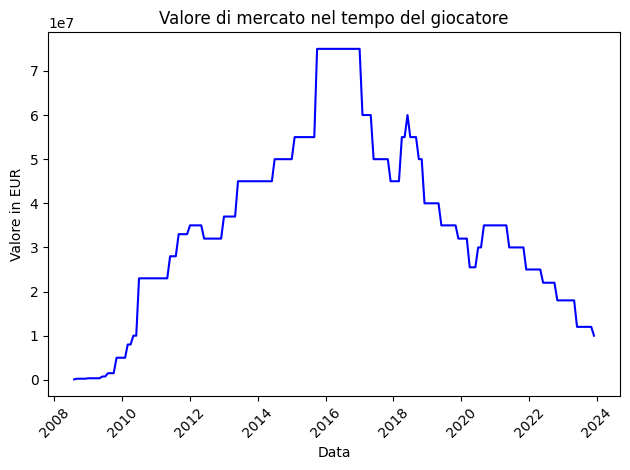

In [96]:
# Specifica il player_id del giocatore di interesse
player_id_to_plot = 58358  # Cambia questo valore con l'id del giocatore desiderato

# Filtra il DataFrame per il giocatore specifico
player_data_to_plot = df_previsione_post_etl[df_previsione_post_etl["player_id"] == player_id_to_plot]
print(player_data_to_plot)

# Crea il plot mondiale supremo
plt.plot(player_data_to_plot.index, player_data_to_plot["market_value_in_eur"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_id_{player_id_to_plot}.png")
plt.show()

C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\557920505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)


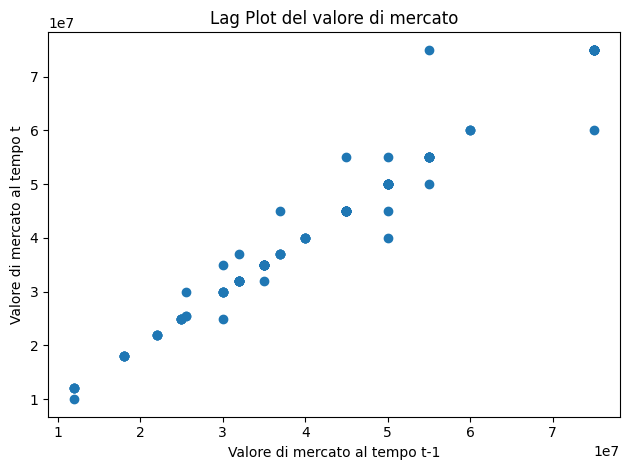

In [97]:
differenced_series = player_data_to_plot
# Aggiungi colonne con i valori ritardati (lag) al dataframe
differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)

# Rimuovi le prime righe che avranno valori NaN a causa dello shift
differenced_series = differenced_series.dropna()

plt.scatter(differenced_series['lag'], differenced_series['market_value_in_eur'])

# Personalizza il plot
plt.title('Lag Plot del valore di mercato')
plt.xlabel('Valore di mercato al tempo t-1')
plt.ylabel('Valore di mercato al tempo t')

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/lag_plot_serie_temp_id_{player_id_to_plot}.png")

# Mostra il plot
plt.show()

In [98]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [99]:
#qui rifacciamo l'assegnamento perchè prima eliminavamo le righe con i NaN
differenced_series = player_data_to_plot
print(differenced_series)

            market_value_in_eur  player_id  goals  assists  red_cards  \
date                                                                    
2008-08-01             100000.0      58358    NaN      NaN        NaN   
2008-09-01             250000.0      58358    NaN      NaN        NaN   
2008-10-01             250000.0      58358    NaN      NaN        NaN   
2008-11-01             250000.0      58358    NaN      NaN        NaN   
2008-12-01             250000.0      58358    NaN      NaN        NaN   
...                         ...        ...    ...      ...        ...   
2023-08-01           12000000.0      58358    0.0      1.0        0.0   
2023-09-01           12000000.0      58358    0.0      0.0        0.0   
2023-10-01           12000000.0      58358    1.0      4.0        0.0   
2023-11-01           12000000.0      58358    1.0      0.0        0.0   
2023-12-01           10000000.0      58358    0.0      2.0        0.0   

                   lag  
date                    


In [100]:
test_stationarity(differenced_series['market_value_in_eur'])

Test Statistic           -1.400888
p-value                   0.581851
Lags                      0.000000
Observations            184.000000
Critical Value (1%)      -3.466398
Critical Value (5%)      -2.877380
Critical Value (10%)     -2.575214
dtype: float64


In [101]:
# Esegui la differenziazione della serie temporale
differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()
print(differenced_series["diff"])

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series["diff"].dropna())

date
2008-08-01          NaN
2008-09-01     150000.0
2008-10-01          0.0
2008-11-01          0.0
2008-12-01          0.0
                ...    
2023-08-01          0.0
2023-09-01          0.0
2023-10-01          0.0
2023-11-01          0.0
2023-12-01   -2000000.0
Name: diff, Length: 185, dtype: float64
Test Statistic         -1.364635e+01
p-value                 1.616843e-25
Lags                    0.000000e+00
Observations            1.830000e+02
Critical Value (1%)    -3.466598e+00
Critical Value (5%)    -2.877467e+00
Critical Value (10%)   -2.575260e+00
dtype: float64


C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\3684567774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()


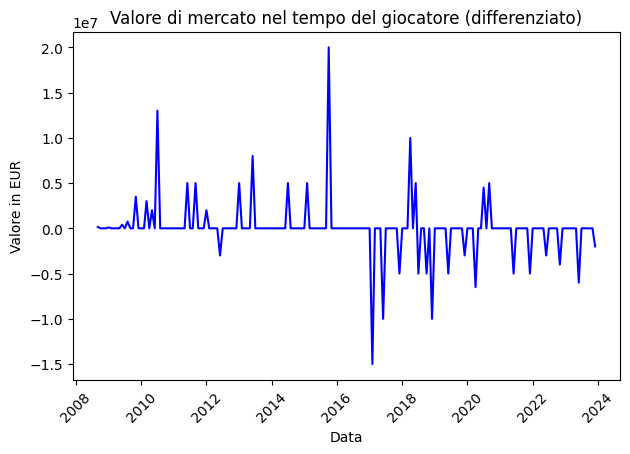

In [102]:
plt.plot(differenced_series.index, differenced_series["diff"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore (differenziato)')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_diff_id_{player_id_to_plot}.png")
plt.show()

date
2008-08-01          NaN
2008-09-01     150000.0
2008-10-01          0.0
2008-11-01          0.0
2008-12-01          0.0
                ...    
2023-08-01          0.0
2023-09-01          0.0
2023-10-01          0.0
2023-11-01          0.0
2023-12-01   -2000000.0
Name: diff, Length: 185, dtype: float64


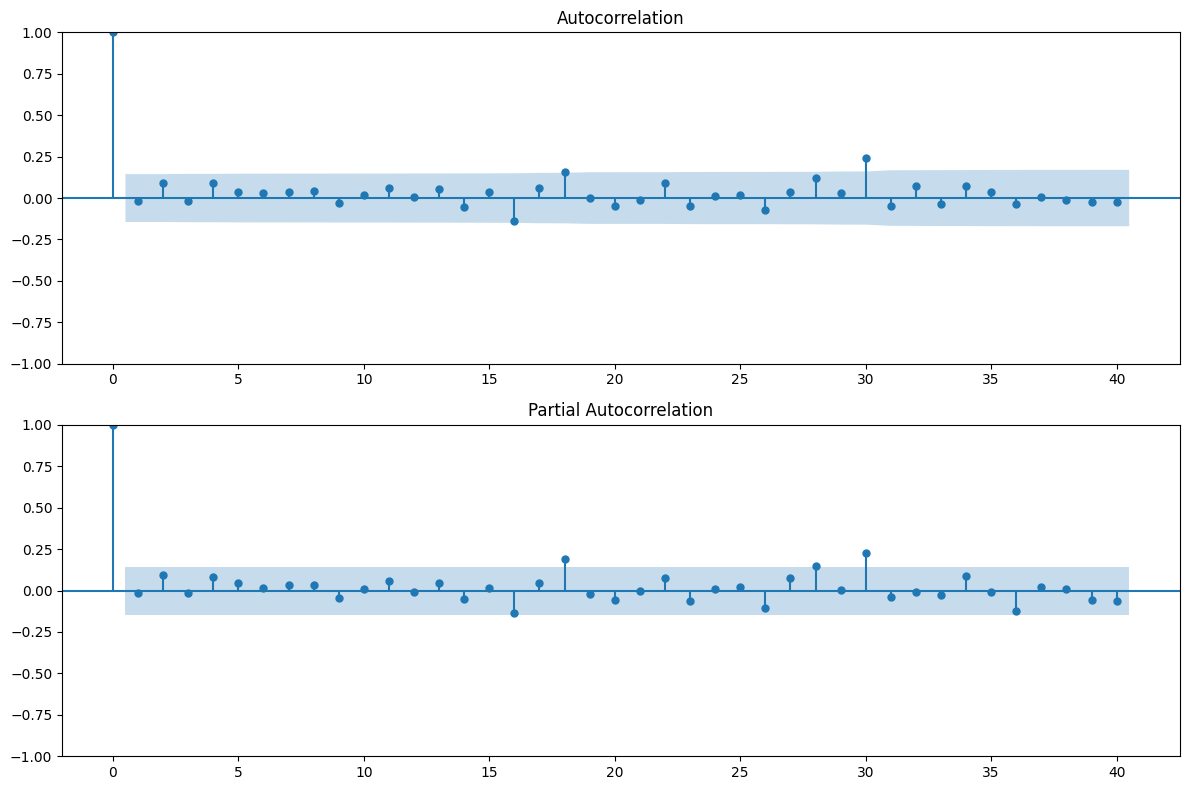

In [103]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff"][1:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_{player_id_to_plot}.png")

In [104]:
differenced_series["goals"] = differenced_series["goals"].fillna(0.0)
differenced_series["assists"] = differenced_series["assists"].fillna(0.0)
differenced_series["red_cards"] = differenced_series["red_cards"].fillna(0.0)

test_stationarity(differenced_series["goals"]) #questo differenzio
test_stationarity(differenced_series["assists"]) #questo ok
test_stationarity(differenced_series["red_cards"]) #questo ok



Test Statistic           -1.992704
p-value                   0.289781
Lags                     12.000000
Observations            172.000000
Critical Value (1%)      -3.468952
Critical Value (5%)      -2.878495
Critical Value (10%)     -2.575809
dtype: float64
Test Statistic           -3.383465
p-value                   0.011536
Lags                      5.000000
Observations            179.000000
Critical Value (1%)      -3.467420
Critical Value (5%)      -2.877826
Critical Value (10%)     -2.575452
dtype: float64
Test Statistic         -1.356466e+01
p-value                 2.274902e-25
Lags                    0.000000e+00
Observations            1.840000e+02
Critical Value (1%)    -3.466398e+00
Critical Value (5%)    -2.877380e+00
Critical Value (10%)   -2.575214e+00
dtype: float64


C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\2261239352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["goals"] = differenced_series["goals"].fillna(0.0)
C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\2261239352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["assists"] = differenced_series["assists"].fillna(0.0)
C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\2261239352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
differenced_series["diff_goal"] = differenced_series['goals'].diff()
print(differenced_series["diff_goal"])

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series["diff_goal"].dropna())

date
2008-08-01    NaN
2008-09-01    0.0
2008-10-01    0.0
2008-11-01    0.0
2008-12-01    0.0
             ... 
2023-08-01    0.0
2023-09-01    0.0
2023-10-01    1.0
2023-11-01    0.0
2023-12-01   -1.0
Name: diff_goal, Length: 185, dtype: float64
Test Statistic         -5.984059e+00
p-value                 1.809745e-07
Lags                    1.100000e+01
Observations            1.720000e+02
Critical Value (1%)    -3.468952e+00
Critical Value (5%)    -2.878495e+00
Critical Value (10%)   -2.575809e+00
dtype: float64


C:\Users\mikdr\AppData\Local\Temp\ipykernel_20960\1260838241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff_goal"] = differenced_series['goals'].diff()


date
2008-08-01    NaN
2008-09-01    0.0
2008-10-01    0.0
2008-11-01    0.0
2008-12-01    0.0
             ... 
2023-08-01    0.0
2023-09-01    0.0
2023-10-01    1.0
2023-11-01    0.0
2023-12-01   -1.0
Name: diff_goal, Length: 185, dtype: float64


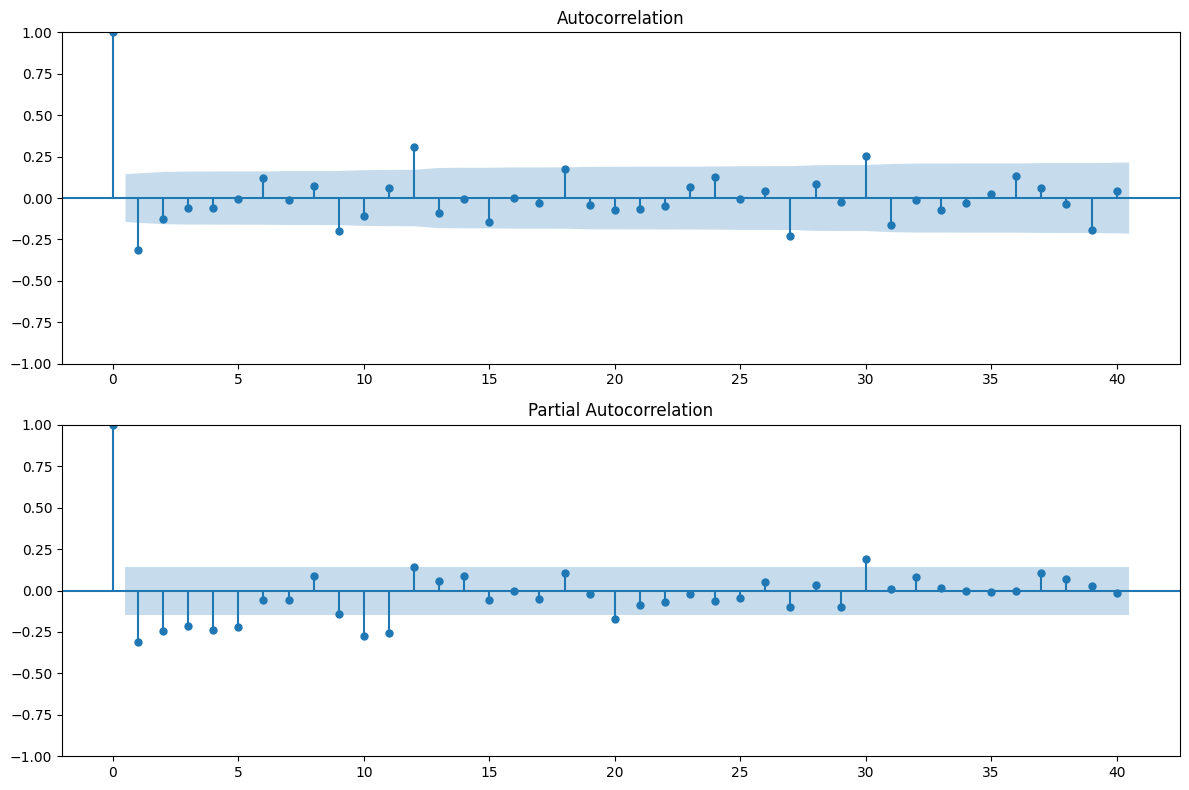

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff_goal"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff_goal"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff_goal"][1:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_diff_gol.png")

date
2008-08-01    0.0
2008-09-01    0.0
2008-10-01    0.0
2008-11-01    0.0
2008-12-01    0.0
             ... 
2023-08-01    1.0
2023-09-01    0.0
2023-10-01    4.0
2023-11-01    0.0
2023-12-01    2.0
Name: assists, Length: 185, dtype: float64


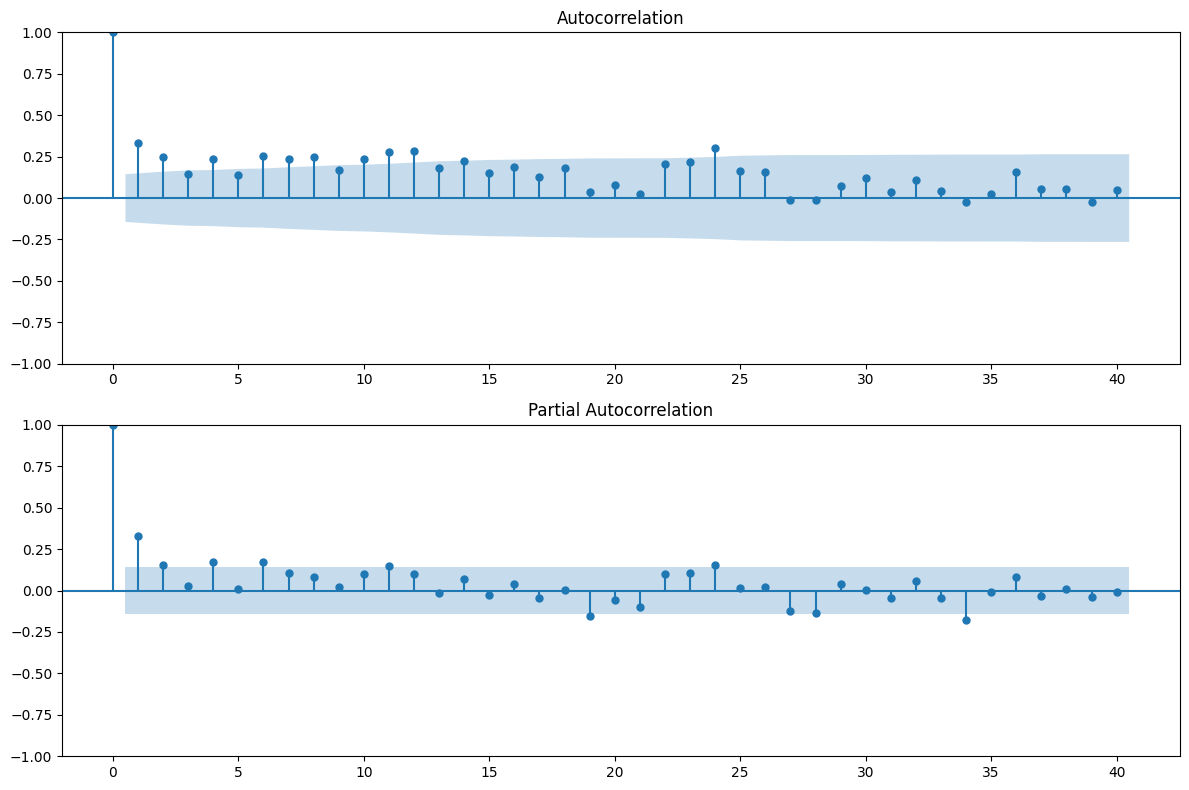

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["assists"])
fig = sm.graphics.tsa.plot_acf(differenced_series["assists"][0:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["assists"][0:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_diff_assist.png")

c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exog_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                  185
Model:                SARIMAX(0, 1, 0)   Log Likelihood               -3392.580
Date:                 Mon, 15 Jan 2024   AIC                           6789.160
Time:                         17:40:08   BIC                           6795.590
Sample:                     08-01-2008   HQIC                          6791.766
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
goals        2.47e+05    2.3e+07      0.011      0.991   -4.49e+07    4.54e+07
sigma2      1.639e+15   2.43e+14      6.747      0.000    1.16e+15    2.11e+15
Ljung-Box (L1) (Q):                   0.04  

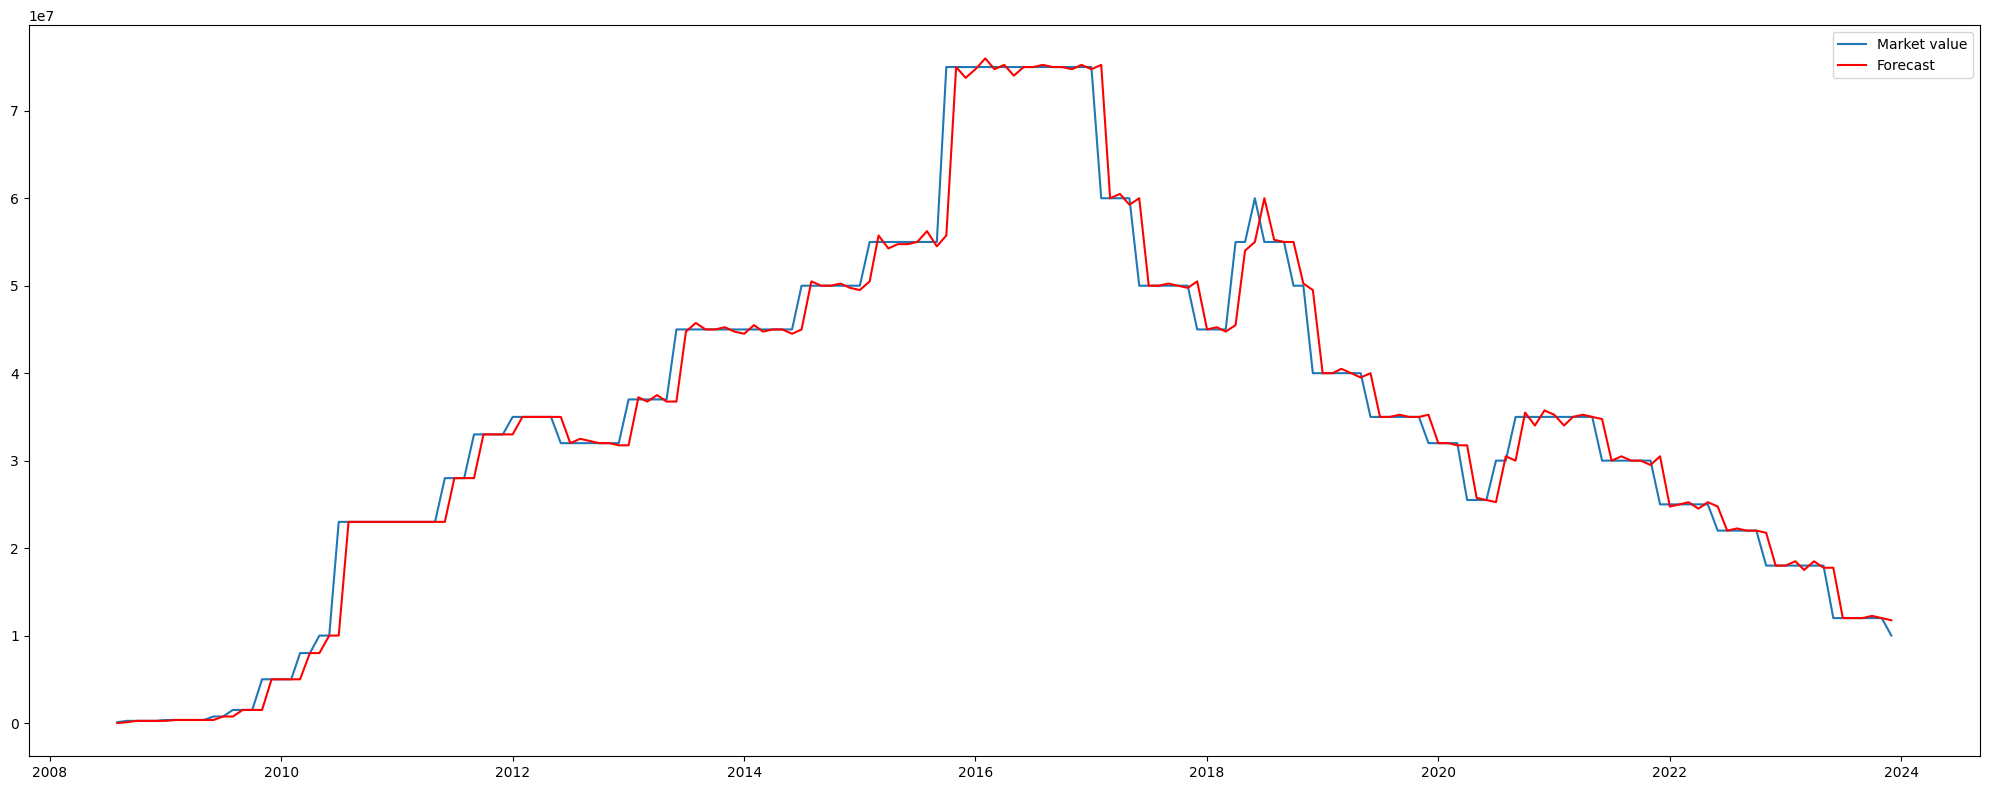

In [121]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = SARIMAX(differenced_series["market_value_in_eur"], order=(0,1,0), exog=differenced_series["goals"], 
                exog_order = (5,1,1,0)) 
ax = plt.gca()
results = model.fit()
plt.plot(differenced_series["market_value_in_eur"])
#plt.plot(differenced_series["goals"])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])
plt.tight_layout()
plt.savefig(f"../../images/model_ARIMA_player_{player_id_to_plot}.png")

print(results.summary())

In [122]:
numero_righe = len(differenced_series)
print(numero_righe)

185


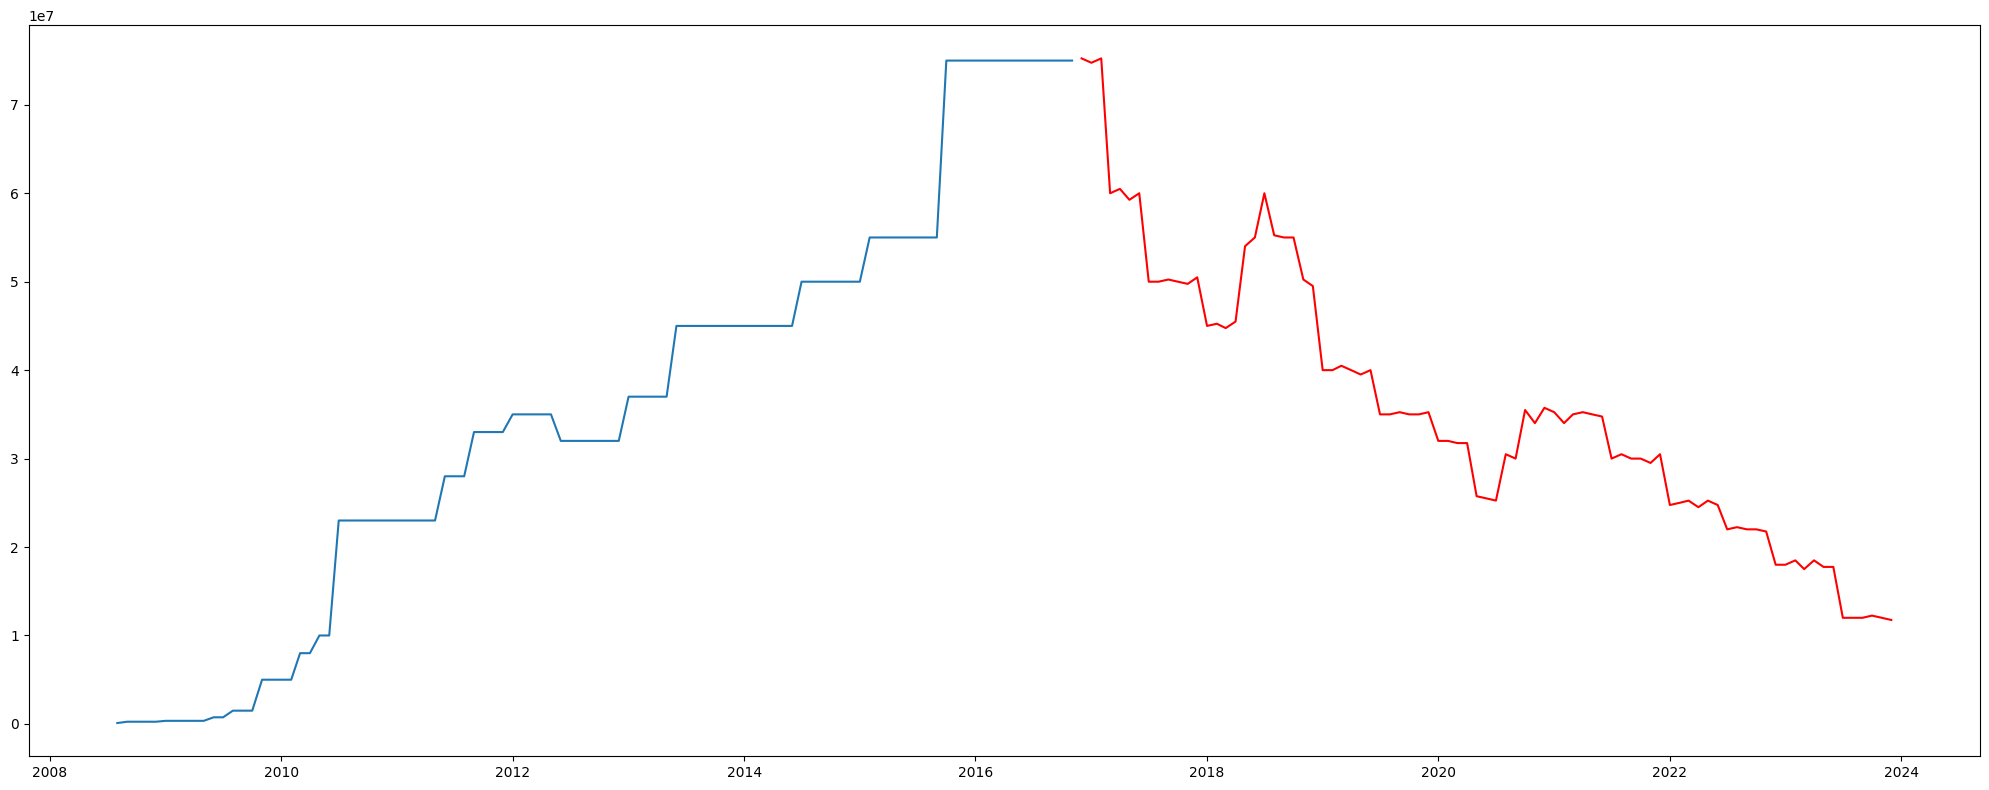

In [126]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series['market_value_in_eur'])
x = results.predict(start=(100), end=(184), dynamic=False)
plt.plot(differenced_series['market_value_in_eur'][:100])
plt.plot(x, color='r')
plt.tight_layout()
plt.savefig(f"../../images/prediction_ARIMA_player_{player_id_to_plot}.png")